In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
from PIL import Image
import requests
from io import BytesIO
import torch
import torchvision
import torchvision.transforms as transforms
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader
import torch.autograd as autograd
from torch import Tensor  

In [2]:
df=pd.read_csv("dress_patterns.csv")
df.drop(["_unit_id"],axis=1,inplace=True)
print(df.head(10))
print(df.columns)
print(df.info())

'''
print(pd.get_dummies(df,"category", drop_first=True))
hel=pd.get_dummies(df["category"], drop_first=True)
new_df=pd.concat([df["image_url"],hel],axis=1)
print(new_df.columns)
'''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    category  ...                                          image_url
0       ikat  ...  http://s3-eu-west-1.amazonaws.com/we-attribute...
1      plain  ...  http://s3-eu-west-1.amazonaws.com/we-attribute...
2  polka dot  ...  http://s3-eu-west-1.amazonaws.com/we-attribute...
3      plain  ...  http://s3-eu-west-1.amazonaws.com/we-attribute...
4   geometry  ...  http://s3-eu-west-1.amazonaws.com/we-attribute...
5   geometry  ...  http://s3-eu-west-1.amazonaws.com/we-attribute...
6      plain  ...  http://s3-eu-west-1.amazonaws.com/we-attribute...
7      plain  ...  http://s3-eu-west-1.amazonaws.com/we-attribute...
8     floral  ...  http://s3-eu-west-1.amazonaws.com/we-attribute...
9      plain  ...  http://s3-eu-west-1.amazonaws.com/we-attribute...

[10 rows x 3 columns]
Index(['category', 'category:confidence', 'image_url'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15702 entries, 0 to 15701
Data columns (total 3 columns):
category               15702 non-null 

http://s3-eu-west-1.amazonaws.com/we-attributes/dress/23/5f635c0fa59f4270a6953f67dcddcda3.jpg.png


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: `item` has been deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  


(400, 600)
plain          8385
floral         2776
stripes         701
polka dot       651
OTHER           513
tribal          507
squares         439
ikat            355
animal          352
geometry        342
cartoon         261
scales          112
chevron          96
letter_numb      82
houndstooth      66
stars            45
skull            19
Name: category, dtype: int64


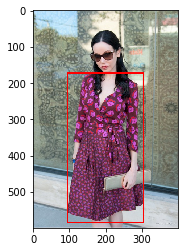

In [3]:
#print(df["image_url"])
print(df["image_url"].head(1).item())
response = requests.get(df["image_url"].head(1).item())
img = Image.open(BytesIO(response.content))
plt.imshow(img)
print(img.size)
print(df.category.value_counts())

In [4]:
for index,row in df[df["category"]=="stripes"].iterrows():
    print(row["image_url"])

http://s3-eu-west-1.amazonaws.com/we-attributes/dress/126/dcd3a334a64345948cc1a686d91c05e2.jpg.png
http://s3-eu-west-1.amazonaws.com/we-attributes/dress/155/57646ea108564dd1853c7aae134175a5.jpg.png
http://s3-eu-west-1.amazonaws.com/we-attributes/dress/470/fb3c0c30ac77487c82c531aaf6e31664.jpg.png
http://s3-eu-west-1.amazonaws.com/we-attributes/dress/496/aeb9d7d2fedc4d198ce82e6e72b3945f.jpg.png
http://s3-eu-west-1.amazonaws.com/we-attributes/dress/626/2fbb74bb29c14cce8c02a4363e9ccb34.jpg.png
http://s3-eu-west-1.amazonaws.com/we-attributes/dress/659/eed202e81a2b438bab9f32dc478d890d.jpg.png
http://s3-eu-west-1.amazonaws.com/we-attributes/dress/668/3e1123a9cfcd4063a5a332e9e6e42a82.jpg.png
http://s3-eu-west-1.amazonaws.com/we-attributes/dress/888/cecd019f1847403d80aca554bfee2cd5.jpg.png
http://s3-eu-west-1.amazonaws.com/we-attributes/dress/1013/85cdec340439433ab5622663cf7734e2.jpg.png
http://s3-eu-west-1.amazonaws.com/we-attributes/dress/1516/5bd6d5ac52614cfbaa55bfd14fe8e619.jpg.png
http://s

In [5]:
hel1=torch.zeros([1,224, 224], dtype=torch.int32)
hel2=torch.zeros([2,224, 224], dtype=torch.int32)
hell=torch.cat((hel1,hel2),dim=0)
print(hell.shape)

torch.Size([3, 224, 224])


In [0]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
transform=transforms.Compose([ transforms.CenterCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),normalize])


In [0]:
class Image_series(Dataset):
    def __init__(self,root_dir, transform=None):
        self.root_dir=root_dir
        self.transform=transform
    def __len__(self):
        df=pd.read_csv(self.root_dir)
        return len(df)
    def __getitem__(self,idx):
        df= pd.read_csv(self.root_dir)
        #print(df.category.value_counts())
        response = requests.get(df.loc[idx,"image_url"])
        img = Image.open(BytesIO(response.content))
        #scaler= MinMaxScaler(feature_range=(0,1)) #Applying scaling to columns in the dataframe\n",
        #sel=scaler.fit_transform(sel)
        df.drop(["_unit_id"],axis=1,inplace=True)
        df["category"] = df["category"].astype('category')
        df["category_n"] = df["category"].cat.codes
        df.drop('category',axis=1,inplace=True)
        res=df.loc[idx,"category_n"]
        #print(df.head(5))
        if(self.transform):
            sample=self.transform(img)
        #print("sample shape",sample.shape)
        result=sample.view(3,224,224)
        if(result.shape==[1,224,224]):
            hel2=torch.zeros([2,224, 224], dtype=torch.int32)
            result=torch.cat((result,hel2),dim=0)
        #print("result shape",result.shape)
        return(result,res)

In [0]:
image_data=Image_series(root_dir="dress_train.csv",transform=transform)

In [0]:
dataloader = DataLoader(image_data, batch_size=1,shuffle=True,drop_last=True)

In [10]:
print(image_data[0])

(tensor([[[ 1.9749,  1.9235,  1.8893,  ..., -0.0116,  1.7694,  2.1290],
         [ 1.9749,  1.9064,  1.9064,  ...,  0.2453,  1.7865,  2.1975],
         [ 1.9749,  1.8893,  1.9407,  ...,  0.6049,  1.8037,  2.0948],
         ...,
         [ 1.8722,  1.8550,  1.8379,  ...,  2.0777,  2.0263,  2.0434],
         [ 1.8550,  1.8379,  1.8208,  ...,  2.0605,  2.0434,  2.0092],
         [ 1.8379,  1.8208,  1.8208,  ...,  2.0092,  2.0777,  2.0605]],

        [[ 2.1485,  2.0959,  2.0609,  ...,  0.1702,  2.0784,  2.3060],
         [ 2.1310,  2.0784,  2.0784,  ...,  0.4328,  2.0959,  2.3761],
         [ 2.1310,  2.0434,  2.1134,  ...,  0.8004,  2.0784,  2.2710],
         ...,
         [ 2.0259,  2.0084,  1.9909,  ...,  2.2535,  2.2010,  2.2185],
         [ 2.0084,  1.9909,  1.9734,  ...,  2.2360,  2.2185,  2.1835],
         [ 1.9909,  1.9734,  1.9734,  ...,  2.1835,  2.2535,  2.2360]],

        [[ 2.3960,  2.3437,  2.3088,  ...,  0.1999,  2.0997,  2.5529],
         [ 2.4308,  2.3263,  2.3263,  ...,  

In [11]:
model = models.resnext50_32x4d(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:05<00:00, 19.8MB/s]


In [12]:
'''
for param in model.parameters():
    param.requires_grad = False
''' 
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                                 nn.Linear(512, 1),
                                 nn.ReLU())
                         #        nn.LogSoftmax(dim=1))
#criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
model.double()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [13]:
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [0]:
for epoch in range(1):
    total_loss=0
    for batch,res in dataloader:
        input_t=batch
        preds=model(input_t.double())
        crit=nn.MSELoss(reduction = "mean")
        print("preds",preds)
        print("res",res)
        loss = crit(preds,res.double())
        total_loss+=loss.item()
        optimizer.zero_grad() #PyTorch accumulates gradients\n",
        loss.backward()
        optimizer.step()
    print("Epoch number",epoch,"total loss after an epoch", total_loss)
  

preds tensor([[0.0217]], dtype=torch.float64, grad_fn=<ReluBackward0>)
res tensor([9], dtype=torch.int8)


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


preds tensor([[32.6969]], dtype=torch.float64, grad_fn=<ReluBackward0>)
res tensor([9], dtype=torch.int8)
preds tensor([[17.0908]], dtype=torch.float64, grad_fn=<ReluBackward0>)
res tensor([9], dtype=torch.int8)
preds tensor([[0.]], dtype=torch.float64, grad_fn=<ReluBackward0>)
res tensor([9], dtype=torch.int8)
preds tensor([[0.]], dtype=torch.float64, grad_fn=<ReluBackward0>)
res tensor([9], dtype=torch.int8)
preds tensor([[0.]], dtype=torch.float64, grad_fn=<ReluBackward0>)
res tensor([9], dtype=torch.int8)
preds tensor([[0.]], dtype=torch.float64, grad_fn=<ReluBackward0>)
res tensor([9], dtype=torch.int8)


In [0]:
image_dat=Image_series(root_dir="dress_test.csv",transform=transform)

In [0]:
testloader = DataLoader(image_dat, batch_size=1,shuffle=True,drop_last=True)

In [0]:
model.eval()

In [0]:
for batch,res in testloader:
        input_t=batch
        preds=model(input_t.double())
        print("Expected",res)
        print("Output",preds)